Intro: Similar to proposal intro?

Methods and Results

First, load the packages.

In [2]:
library(repr)
library(tidyverse)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

Next, load the raisin dataset, eliminate the metadata, and rename the columns with predictor names.

In [3]:
set.seed(123)
raisin_data <- read.table("data/Raisin_Dataset.arff", sep = ",", skip = 18)
colnames(raisin_data) = c("Area", "Perimeter", "MajorAxisLength", "MinorAxisLength",
                          "Eccentricity", "ConvexArea", "Extent", "Class")
head(raisin_data)

,Area,Perimeter,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Class
,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>
1,87524,442.2460,253.2912,0.8197384,90546,0.7586506,1184.040,Kecimen
2,75166,406.6907,243.0324,0.8018052,78789,0.6841296,1121.786,Kecimen
3,90856,442.2670,266.3283,0.7983536,93717,0.6376128,1208.575,Kecimen
4,45928,286.5406,208.7600,0.6849892,47336,0.6995994,844.162,Kecimen
5,79408,352.1908,290.8275,0.5640113,81463,0.7927719,1073.251,Kecimen
6,49242,318.1254,200.1221,0.7773513,51368,0.6584564,881.836,Kecimen


We split the data into training(75%) and testing(25%).

In [4]:
set.seed(123)
raisin_split <- initial_split(raisin_data, prop = 0.75, strata = Class)  
raisin_train <- training(raisin_split)   
raisin_test <- testing(raisin_split)

Then, we obtain the number of observaions grouped by each class for training data.

In [5]:
set.seed(123)
counts <- raisin_train |>
            group_by(Class) |>
            summarize(n = n())
counts

Class,n
<chr>,<int>
Besni,337
Kecimen,337


Examine the mean of the predictors for training data.

In [6]:
set.seed(123)
mean_pred <- raisin_train |>
                select(-Class) |>
                map_dfr(mean)
mean_pred

Area,Perimeter,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
87023.82,429.1558,253.922,0.7816062,90340.22,0.6990537,1162.402


Check if we have any missing data.

In [7]:
sum(is.na(raisin_train))

[1] 0

Visualize the relationship between two predictors, Area and Eccentricity, in a scatterplot using training data.

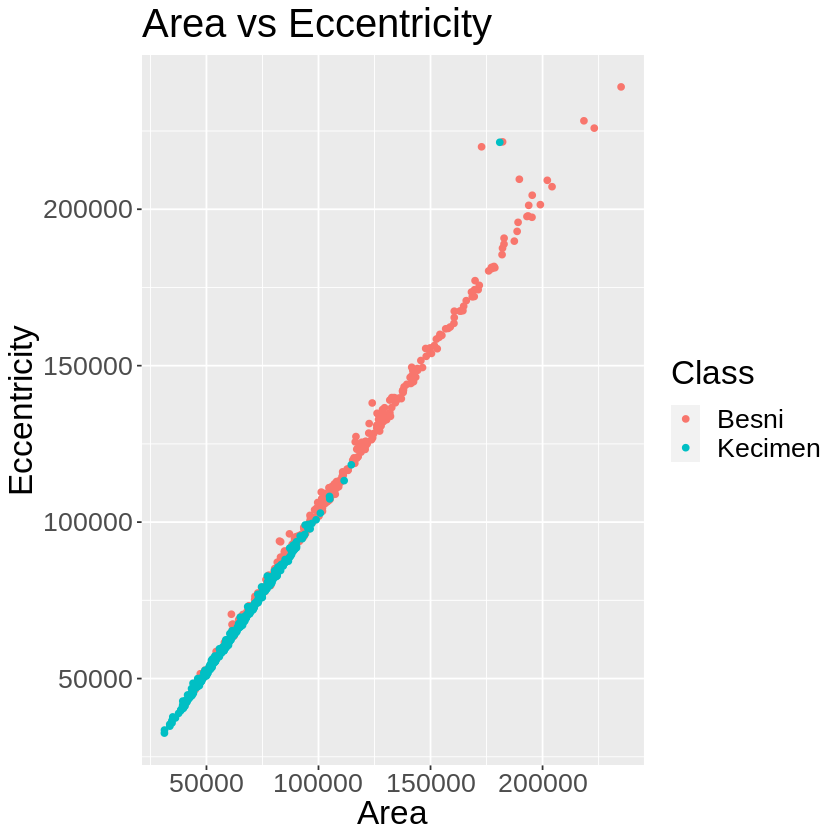

In [8]:
set.seed(123)
raisin_train |>
   ggplot(aes(x = Area, y = Eccentricity,color = Class)) +
     geom_point() +
     labs(x = "Area", y = "Eccentricity") +
  ggtitle("Area vs Eccentricity")+
    theme(text = element_text(size = 20))

According to the scatterplot, there are many overlaps between the two classes. The two factors "Eccentricity" and "Area" are not good predictors together for building model.

Take a look at predictors "MajorAxisLength" and "Eccentricity".

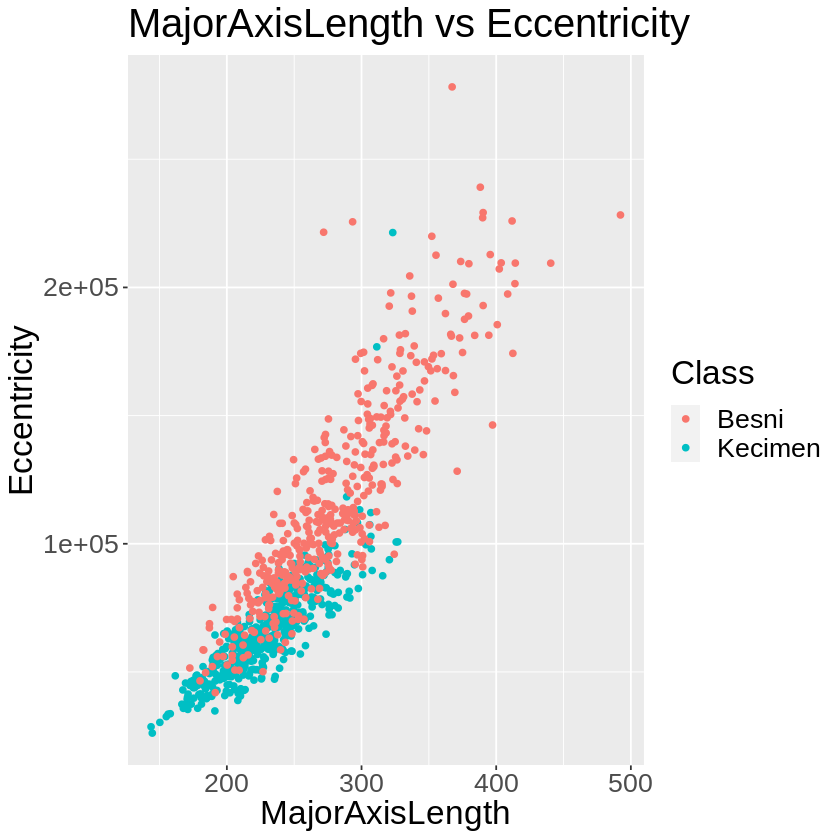

In [9]:
set.seed(123)
find_K <-raisin_data |>
   ggplot(aes(x = MajorAxisLength, y = Eccentricity,color = Class)) +
     geom_point() +
     labs(x = "MajorAxisLength", y = "Eccentricity") +
 ggtitle("MajorAxisLength vs Eccentricity")+
    theme(text = element_text(size = 20))
find_K

The discrimination between the “MajorAxisLength” and “Eccentricity” are relatively high, so they are good predictors for building models.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.7417691,5,0.009084638,Preprocessor1_Model01
6,accuracy,binary,0.8263169,5,0.010987898,Preprocessor1_Model02
11,accuracy,binary,0.8352283,5,0.008314733,Preprocessor1_Model03
16,accuracy,binary,0.8411106,5,0.013768582,Preprocessor1_Model04
21,accuracy,binary,0.8396620,5,0.014094658,Preprocessor1_Model05
26,accuracy,binary,0.8441176,5,0.013787865,Preprocessor1_Model06
31,accuracy,binary,0.8411106,5,0.013382297,Preprocessor1_Model07
36,accuracy,binary,0.8411326,5,0.014134107,Preprocessor1_Model08
41,accuracy,binary,0.8411326,5,0.015451769,Preprocessor1_Model09


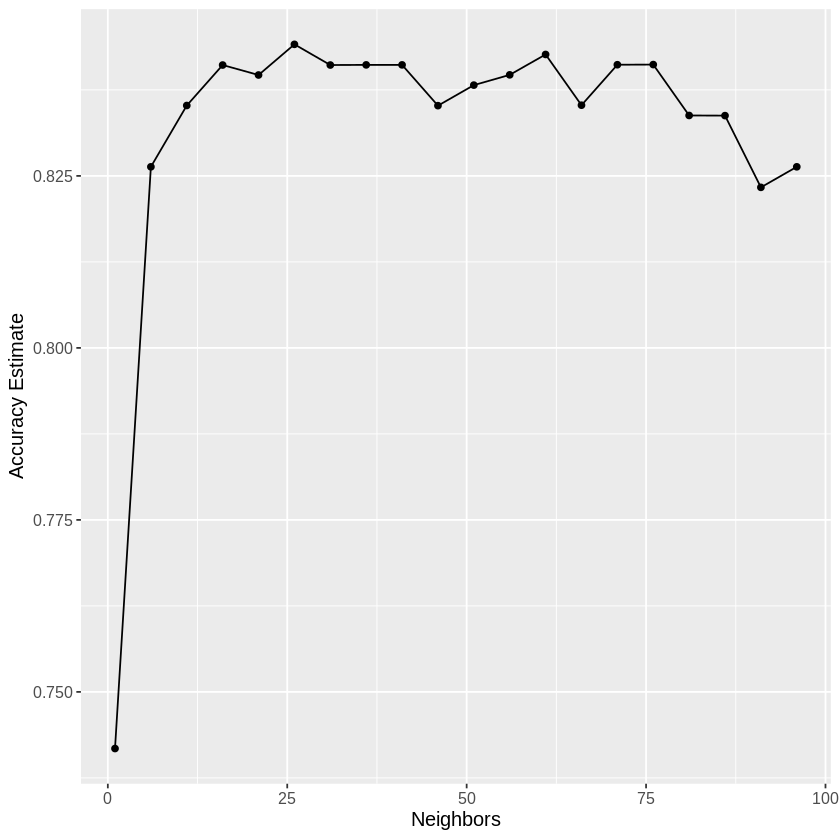

In [10]:
set.seed(123)
raisin_recipe <- recipe(Class ~ MajorAxisLength + Eccentricity, data = raisin_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

raisin_vfold <- vfold_cv(raisin_train, v = 5, strata = Class)

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_results <- workflow() |>
  add_recipe(raisin_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = raisin_vfold, grid = k_vals) |>
  collect_metrics() 

accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracies

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))

accuracy_vs_k

Now,let's nuild our model!

In [11]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 27) |>
  set_engine("kknn") |>
  set_mode("classification")

raisin_data_recipe_2 <- recipe(Class ~ MajorAxisLength + Eccentricity, data = raisin_train) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

raisin_fit<- workflow() |>
  add_recipe(raisin_data_recipe_2) |>
  add_model(knn_spec) |>
  fit(data = raisin_train)





In [12]:
raisin_test_predictions <- predict(raisin_fit, raisin_test) |>  #here you missed a pipe operator
    bind_cols(raisin_test) |>
    mutate(Class = as.factor(Class)) 
raisin_test_predictions

.pred_class,Area,Perimeter,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Class
<fct>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<fct>
Besni,87524,442.2460,253.2912,0.8197384,90546,0.7586506,1184.040,Kecimen
Kecimen,90856,442.2670,266.3283,0.7983536,93717,0.6376128,1208.575,Kecimen
Kecimen,79408,352.1908,290.8275,0.5640113,81463,0.7927719,1073.251,Kecimen
Kecimen,43441,276.6108,201.8131,0.6838823,45133,0.6908556,803.748,Kecimen
Kecimen,33565,261.5543,167.7085,0.7673743,35794,0.6815505,751.413,Kecimen
Kecimen,57346,330.4784,222.4437,0.7395550,59365,0.7236088,928.272,Kecimen
Kecimen,75620,368.2243,263.4593,0.6986273,77493,0.7262774,1059.186,Kecimen
Kecimen,73167,340.0552,276.0152,0.5841058,74545,0.7787369,1010.474,Kecimen
Kecimen,60847,336.9239,231.4657,0.7266602,62492,0.6985878,964.603,Kecimen


In [13]:
accuracy<-raisin_test_predictions |>
    metrics(truth = Class, estimate = .pred_class) |> 
    filter(.metric == "accuracy")

accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8716814


Discussion

References